# Protein stability as a log-linear problem
## Assessing model error

In [1]:
# Modules
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt


## Same mock dataset

In [2]:
df = pd.DataFrame({
    "GdmCl": np.array([
        0.25,
        0.50,
        0.75,
        1,
        1.5,
        1.75,
        2,
        2.5,
        2.75,
        3,
        3.5,
        4
    ], dtype=float),
    "Intensity": np.array([
        101,
        97,
        102,
        96,
        88,
        62,
        52,
        48,
        28,
        20,  # 20 or 19
        26,
        23
    ], dtype=float)
})

df.head(12)



,GdmCl,Intensity
0,0.25,101.0
1,0.50,97.0
2,0.75,102.0
3,1.00,96.0
4,1.50,88.0
5,1.75,62.0
6,2.00,52.0
7,2.50,48.0
8,2.75,28.0
9,3.00,20.0


## Same data manipulations and same transition region.

In [3]:
def rescale(y, ref_min, ref_max):
    return (y - ref_min) / (ref_max - ref_min)


df['N_ratio'] = df.Intensity.apply(rescale, args=(20, 98))
df['K'] = (1 - df.N_ratio) / df.N_ratio
df['logK'] = df.K.map(np.log10)
transition = df[df.GdmCl.between(1.25, 2.80)].copy()


/usr/local/lib/python3.9/site-packages/pandas/core/base.py:937: RuntimeWarning: invalid value encountered in log10
  new_values = map_f(values, mapper)


Recover paramaters estimated from fitted model.

In [4]:
INTERCEPT = np.array(-2.293263723543123)
SLOPE = np.array(1.1350753137863376)



For any model fitted to empirical data, there will be deviations between the
model predictions and the actual measurements. These are due to any factor
outside of the control of the experimental design, think anything from
thermal fluctuations, sample heterogeinity, instrument inaccuracy, pipetting...
The distances between observations and model $y_{obs} - y_{pred}$ are called
**residuals** and allow us to quantify the model errors. 

Below, we calculate the residuals and squared residuals for the transition
region.

In [5]:
transition['logK_pred'] = INTERCEPT + SLOPE * transition.GdmCl
transition['logK_res'] = transition.logK - transition.logK_pred
transition['sqres'] = transition.logK_res ** 2


Here we represent residuals as vertical arrows between observations and
predictions.

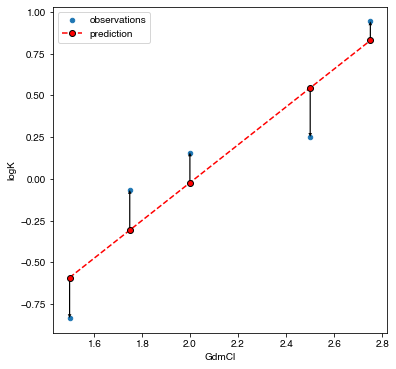

In [6]:
fig = plt.figure(figsize=(6, 6))
ax = fig.subplots(1, 1)
# observations
transition.plot.scatter(
    "GdmCl",
    "logK",
    label="observations",
    zorder=1,
    ax=ax,
)
# predictions
transition.plot(
    "GdmCl",
    "logK_pred",
    color="red",
    label="prediction",
    markeredgecolor="k",
    linestyle="--",
    marker="o",
    zorder=3,
    ax=ax
)
# residual arrows
for i in range(transition.shape[0]):
    ax.arrow(
        x=transition.iloc[i].GdmCl,
        y=transition.iloc[i].logK_pred,
        dx=0,
        dy=transition.iloc[i].logK_res,
        width=0.005,
        length_includes_head=True,
        facecolor="k",
        edgecolor="w",
        lw=4e-5,
        zorder=2,
    )
ax.legend()



Residuals are often associated with the **unexplained** variation in the data.
For this particular case, this means that while the model explains
something about how $\log{K}$ changes as a function of [GdmCl], we can't predict
with absolute certainty what the exact value of $\log{K}$ will be for any one
particular concentration of denaturant, we can only provide an approximation.

A probabilistic interpretation of this situation is that, in repeating this
experiment, we will be willing to accept similar deviations between model and
observations, residuals of similar size. Consequently, different experiments
could have given us sligthly different datasets, yielding different parameter
estimates. It follows that our current model is only one of many possible
lines, so our parameter estimates carry some **uncertainty**.

In [7]:
print(
    f"Fitted equation:\n"
    f"log K = {INTERCEPT.round(2)} + [GdmCl] • {SLOPE.round(2)}"
)

Fitted equation:
log K = -2.29 + [GdmCl] • 1.14


What residuals can be accepted as typical we need to asses depending on the
residuals we've observed so far. By definition, residuals have mean 0 and their
standard deviation can be calculated as follows:

$$\sigma_{res} = \sqrt{\frac{\sum{(y_{obs} - y_{res})^{2}}}{\mathrm{df}_{res}}},$$

where $\mathrm{df}_{res}$ is the number of degrees of freedom of the residuals.
For $n_{obs}$ observations and a linear model with one variable,
$\mathrm{df}_{res} = n_{obs} - 2$.

In [8]:
dfres = transition.shape[0] - 2
sigma = np.sqrt(transition.sqres.sum() / dfres)  # sigma = sqrt(MSE) = sqrt(SSE/df)



Rather than actually repeating the experiment, we can simulate what measurements
we are likely to obtain by adding appropriately *typical* residuals to our
current model. A common assumption is that the residuals follow a Gaussian, so with
mean 0 and $\sigma_{res}$ we can generate datasets that would be indistinguishable
from the one we measured.

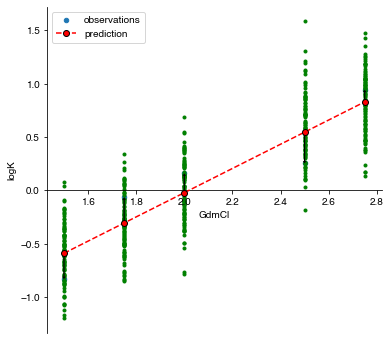

In [9]:
aa = []  # intercepts
bb = []  # slopes
for _ in range(100): # repeat X times
    sim_error = np.random.normal(0, sigma, transition.shape[0]) # Guassian residuals
    simulated = transition.logK_pred + sim_error
    ax.scatter(
        transition.GdmCl,
        simulated,
        color="g",
        marker=".",
    )
    # fit for each dataset
    sim_res = linregress(transition.GdmCl.values, simulated) 
    # track intercepts and slopes
    bb.append(sim_res.slope)
    aa.append(sim_res.intercept)

ax.spines.bottom.set_position(("data", 0))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# show updated figure again
fig


For each simulation we refitted the dataset to a line and kept
track of the intercepts and slopes we were getting.

Text(0.5, 0, 'simulated slopes')

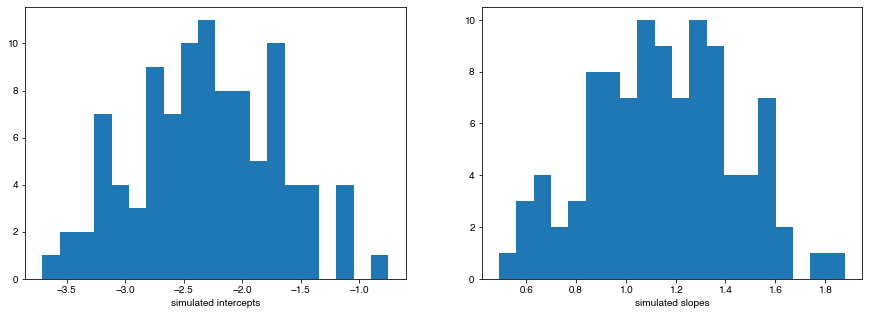

In [10]:
histograms = plt.figure(figsize=(15, 5))
ax0, ax1 = histograms.subplots(1, 2)
ax0.hist(aa, bins=20)
ax0.set_xlabel("simulated intercepts")
ax1.hist(bb, bins=20)
ax1.set_xlabel("simulated slopes")

To express the uncertainty around our parameter, we can report them
together with the standard deviation of their simulated distributions:

In [11]:
std_intercept = np.array(aa).std()
std_slope = np.array(bb).std()
print(
    "Fitted equation with erros:\n"
    f"log K = {INTERCEPT.round(1)} (± {std_intercept.round(1)}) + "
    f"[GdmCl] • {SLOPE.round(1)} (± {std_slope.round(1)})"
)

Fitted equation with erros:
log K = -2.3 (± 0.6) + [GdmCl] • 1.1 (± 0.3)
